In [1]:
%matplotlib inline
import pyfolio as pf

In [2]:
import zipline
from zipline.api import *
from zipline.utils.events import BeforeClose
from zipline.utils.run_algo import run_algorithm
from datetime import datetime
import pytz
import pandas as pd
import pandas_datareader.data as web

In [3]:
!zipline bundles

quandl 2017-09-27 13:50:20.349308
quantopian-quandl 2017-09-27 13:49:19.623490
quantopian-quandl 2017-09-27 10:45:08.190035


In [4]:
candles = 3
ticker = 'AAPL'
from_date = datetime(2000,1,1, tzinfo=pytz.utc)
to_date = datetime(2014,1,1, tzinfo=pytz.utc)
capital_base = 10000

In [5]:
def initialize(context):
    context.i = 0
    context.asset = symbol(ticker)
    schedule_function(func=handle_date_eod,
                      date_rule=date_rules.every_day(),
                      time_rule=time_rules.market_close(minutes=5),
                      calendar=calendars.US_EQUITIES)

def handle_date_eod(context, data):
    context.i += 1
    if context.i < candles:
        return

    #always close previous day
    order_percent(context.asset, 0)

    hist = data.history(context.asset, 
                           ('open', 'high', 'low', 'close'), 
                           bar_count=candles, 
                           frequency="1d")
    current_candle = hist.iloc[-1]
    
    all_negative = ((hist['close'] - hist['open']) < 0).all()
    if all_negative:
        #current_candle = hist.iloc[-1]
        lower_bound = current_candle['low'] + (current_candle['high']-current_candle['low'])*0.75
        if current_candle['close'] > lower_bound:
            act_price = data.current(context.asset, 'price')
            print('=====\n{}'.format(context.datetime))
            print(hist)
            order_percent(context.asset, 5)
            record(history=hist)
def handle_data(context, data):
    pass

In [6]:
def load_data(ticker, from_date, to_date):
    from collections import OrderedDict
    data = OrderedDict()
    
    df = web.DataReader(ticker, 'yahoo', from_date, to_date)
    df.dropna(inplace=True)
    df.drop(['Adj Close'], axis=1, inplace=True)
    
    data[ticker] = df
    panel = pd.Panel(data)
    panel.minor_axis = ['open', 'high', 'low', 'close', 'volume']
    panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

    return panel

In [7]:
#spy_df = load_data('SPY', from_date, to_date)

In [8]:
results = run_algorithm(from_date, 
                        to_date,
                        initialize,
                        capital_base,
                        handle_data=handle_data,
                        #data=spy_df    
                       )

/usr/local/lib/python3.4/site-packages/empyrical/stats.py:522: RuntimeWarning: invalid value encountered in double_scalars
  sortino = mu / dsr


=====
2000-05-30 20:00:00+00:00
                           close   high    low   open
2000-05-25 00:00:00+00:00  87.27  92.66  86.00  88.50
2000-05-26 00:00:00+00:00  86.37  89.87  85.25  88.00
2000-05-30 00:00:00+00:00  87.56  88.12  81.75  87.62
=====
2001-05-24 20:00:00+00:00
                           close   high    low   open
2001-05-22 00:00:00+00:00  23.50  24.13  23.40  24.00
2001-05-23 00:00:00+00:00  23.23  23.75  22.86  23.75
2001-05-24 00:00:00+00:00  23.20  23.30  22.62  23.29
=====
2002-02-20 21:00:00+00:00
                           close   high    low   open
2002-02-15 00:00:00+00:00  23.90  24.98  23.85  24.98
2002-02-19 00:00:00+00:00  22.62  23.90  22.48  23.76
2002-02-20 00:00:00+00:00  23.13  23.20  22.35  23.20
=====
2003-07-16 20:00:00+00:00
                           close   high    low   open
2003-07-14 00:00:00+00:00  19.90  20.40  19.87  20.01
2003-07-15 00:00:00+00:00  19.61  20.24  19.43  20.02
2003-07-16 00:00:00+00:00  19.87  20.00  19.38  19.97
=====
20

In [9]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [10]:
returns[-5:]

2013-12-24 00:00:00+00:00   -0.017890
2013-12-26 00:00:00+00:00   -0.028377
2013-12-27 00:00:00+00:00   -0.029516
2013-12-30 00:00:00+00:00   -0.044463
2013-12-31 00:00:00+00:00    0.054301
Name: returns, dtype: float64

In [11]:
len(positions)*2-len(transactions)

6819

In [12]:
positions

,Equity(2696 [AAPL]),cash
index,,
2000-05-31 00:00:00+00:00,4.796400e+04,-3.796828e+04
2000-06-01 00:00:00+00:00,5.088752e+04,-3.796828e+04
2000-06-02 00:00:00+00:00,5.285176e+04,-3.796828e+04
2000-06-05 00:00:00+00:00,5.213801e+04,-3.796828e+04
2000-06-06 00:00:00+00:00,5.302877e+04,-3.796828e+04
2000-06-07 00:00:00+00:00,5.513576e+04,-3.796828e+04
2000-06-08 00:00:00+00:00,5.413651e+04,-3.796828e+04
2000-06-09 00:00:00+00:00,5.467325e+04,-3.796828e+04
2000-06-12 00:00:00+00:00,5.206949e+04,-3.796828e+04


In [13]:
transactions

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2000-05-31 20:00:00+00:00,571,None,2000-05-31 20:00:00+00:00,a6976f573de64188b1eeeddc3e7f821e,84.000000,Equity(2696 [AAPL]),Equity(2696 [AAPL]),-4.796400e+04
2001-05-25 20:00:00+00:00,-2472,None,2001-05-25 20:00:00+00:00,3c56190e57d24177b6b63c115f52615b,22.759998,Equity(2696 [AAPL]),Equity(2696 [AAPL]),5.626272e+04
2002-02-21 21:00:00+00:00,-2699,None,2002-02-21 21:00:00+00:00,9ce1b5b36fb5404e9823e7427aa49181,21.500000,Equity(2696 [AAPL]),Equity(2696 [AAPL]),5.802850e+04
2003-07-17 20:00:00+00:00,-949,None,2003-07-17 20:00:00+00:00,9d8b8fd6bc474bbf8729074e923cc918,20.900000,Equity(2696 [AAPL]),Equity(2696 [AAPL]),1.983410e+04
2007-03-30 20:00:00+00:00,-44654,None,2007-03-30 20:00:00+00:00,add9fc41c48747f8b179bb8ee8b7c954,92.909960,Equity(2696 [AAPL]),Equity(2696 [AAPL]),4.148801e+06
2007-09-10 20:00:00+00:00,-111989,None,2007-09-10 20:00:00+00:00,0476ca249ba644b7a25f493942cf6aab,136.709939,Equity(2696 [AAPL]),Equity(2696 [AAPL]),1.531001e+07
2007-11-28 21:00:00+00:00,-273709,None,2007-11-28 21:00:00+00:00,c29202e4c852415eb8b081dda213dd64,180.219201,Equity(2696 [AAPL]),Equity(2696 [AAPL]),4.932762e+07
2008-07-22 20:00:00+00:00,-130480,None,2008-07-22 20:00:00+00:00,384cddfaf36641d9b14a6cadde6bdf8e,162.019939,Equity(2696 [AAPL]),Equity(2696 [AAPL]),2.114036e+07
2009-07-07 20:00:00+00:00,393253,None,2009-07-07 20:00:00+00:00,4798b989e33e43bdb12eb71c610e8ce4,135.407705,Equity(2696 [AAPL]),Equity(2696 [AAPL]),-5.324949e+07
2010-05-18 20:00:00+00:00,-164556,None,2010-05-18 20:00:00+00:00,3ed1a57aed624028b143d2d72762ac8e,252.359125,Equity(2696 [AAPL]),Equity(2696 [AAPL]),4.152721e+07


In [14]:
results.history['2000-05-30']

,close,high,low,open
2000-05-25 00:00:00+00:00,87.27,92.66,86.00,88.50
2000-05-26 00:00:00+00:00,86.37,89.87,85.25,88.00
2000-05-30 00:00:00+00:00,87.56,88.12,81.75,87.62


Entire data start date: 2000-01-03
Entire data end date: 2013-12-31
Backtest months: 167


/usr/local/lib/python3.4/site-packages/empyrical/stats.py:273: RuntimeWarning: invalid value encountered in double_scalars
  annual_return = (1. + cum_returns_final) ** (1. / num_years) - 1
/usr/local/lib/python3.4/site-packages/empyrical/stats.py:918: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


,Backtest
Annual return,nan%
Cumulative returns,-3329367.5%
Annual volatility,1255.5%
Sharpe ratio,0.15
Calmar ratio,NaN
Stability,NaN
Max drawdown,-55515.7%
Omega ratio,1.12
Sortino ratio,0.20
Skew,-9.52


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,55515.68,2000-09-01,2007-12-28,2008-01-22,1928
1,937.86,2009-01-20,2012-09-19,NaT,NaN
2,189.92,2008-02-26,2008-05-13,2008-09-17,147
3,47.56,2000-07-12,2000-08-15,2000-08-29,35
4,43.78,2008-09-17,2008-09-19,2008-09-23,5


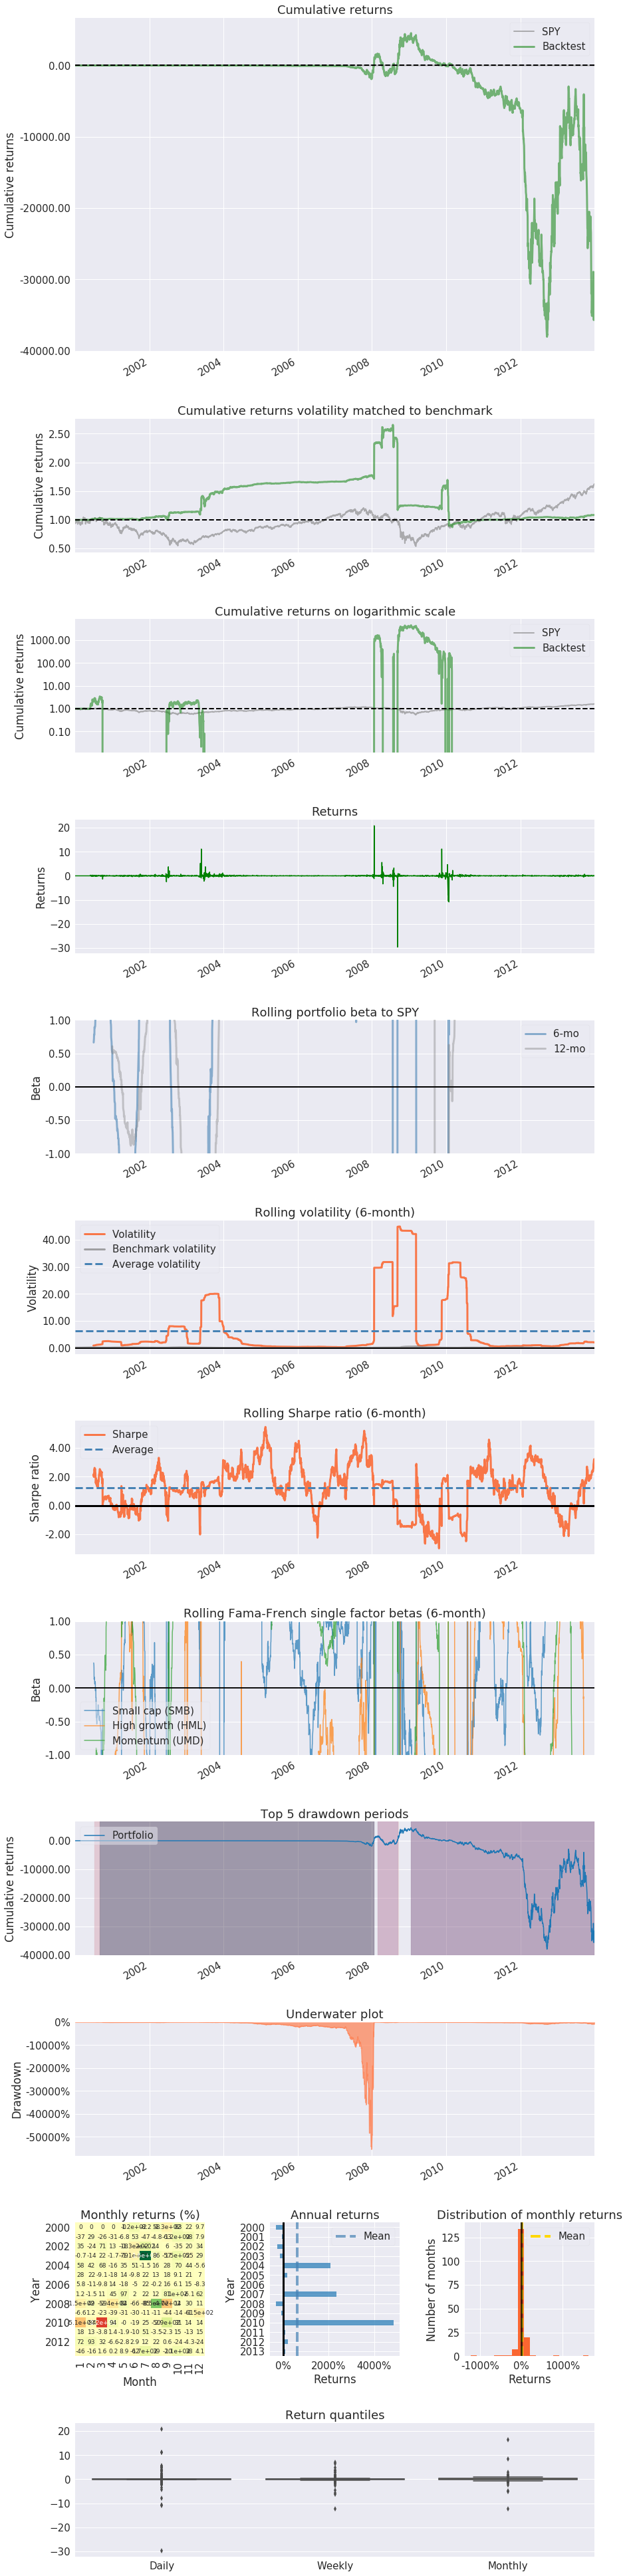

Stress Events,mean,min,max
Dotcom,1.20%,-23.98%,29.25%
Lehmann,-61.33%,-2964.48%,326.82%
9/11,4.18%,-40.87%,72.66%
US downgrade/European Debt Crisis,0.14%,-14.10%,16.73%
Fukushima,-0.63%,-13.23%,8.48%
US Housing,0.86%,-9.37%,12.05%
EZB IR Event,-0.53%,-5.60%,5.37%
Aug07,0.81%,-13.54%,14.79%
Mar08,-5.17%,-46.62%,42.29%
Sept08,-129.41%,-2964.48%,97.84%


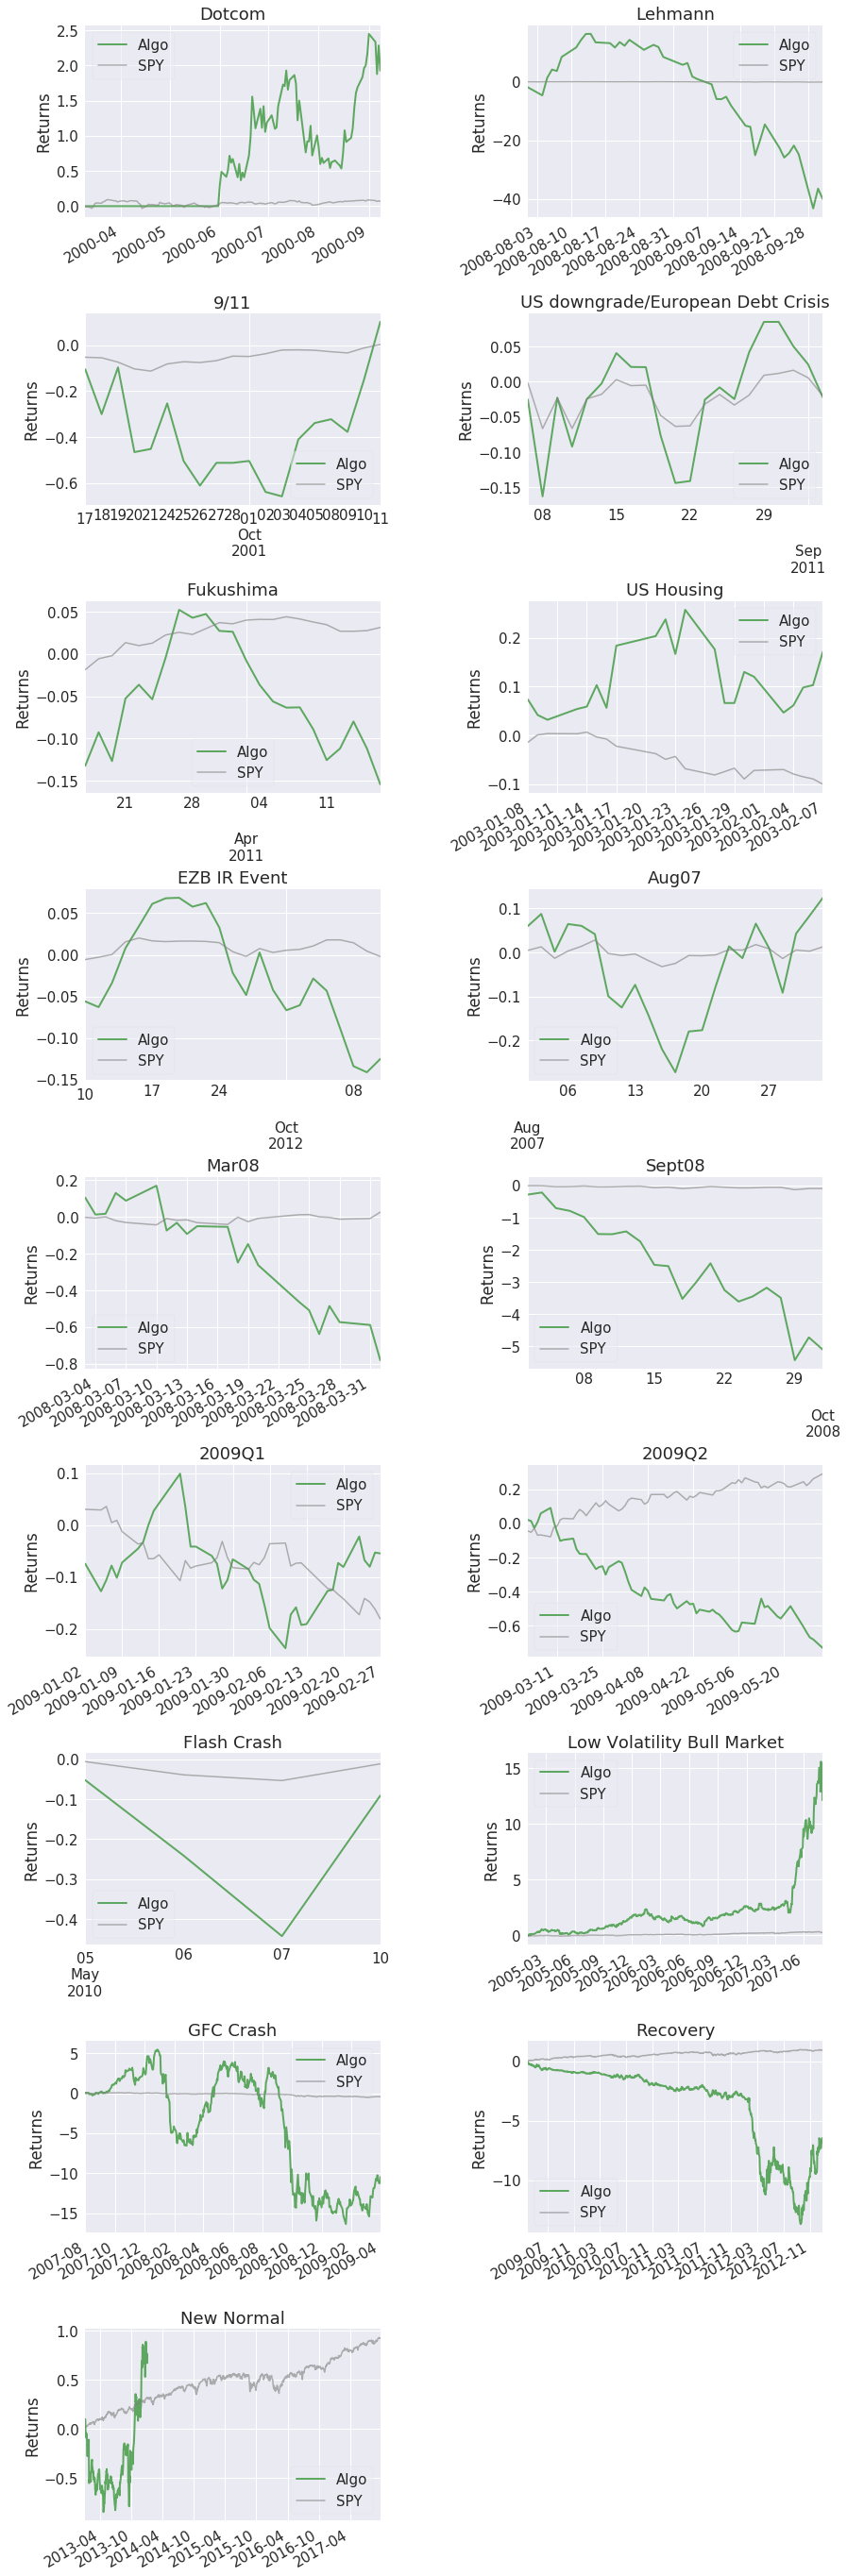

Top 10 long positions of all time,max
AAPL,75024.13%


Top 10 short positions of all time,max
AAPL,-222536.73%


Top 10 positions of all time,max
AAPL,222536.73%


All positions ever held,max
AAPL,222536.73%


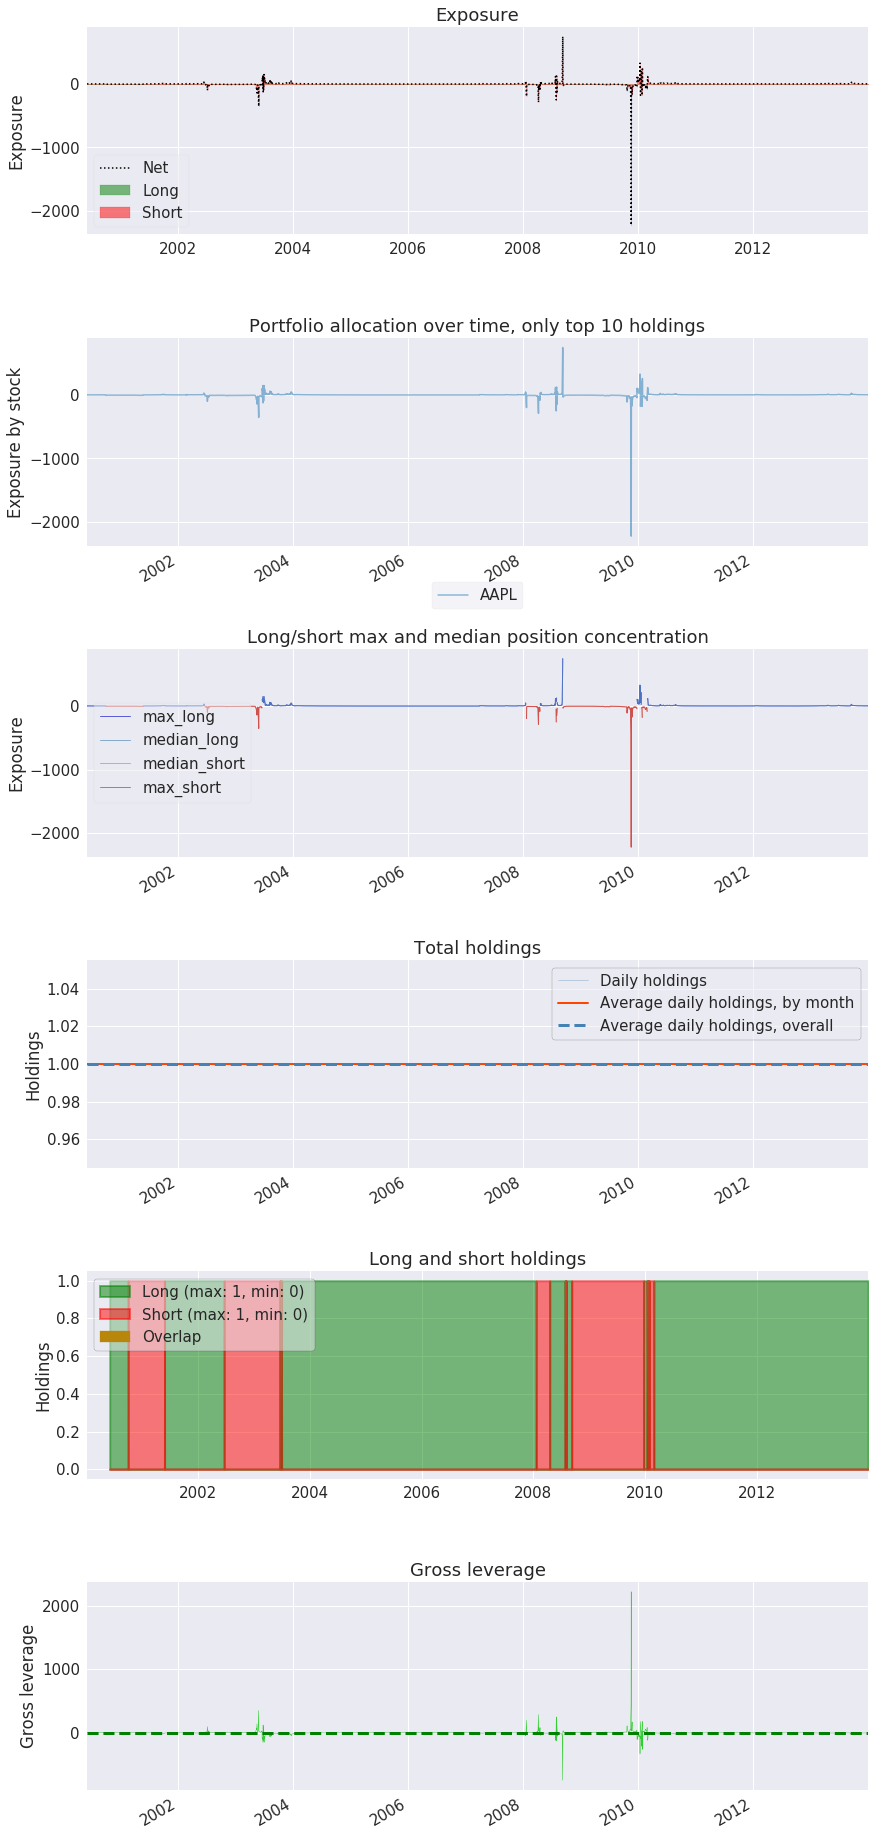

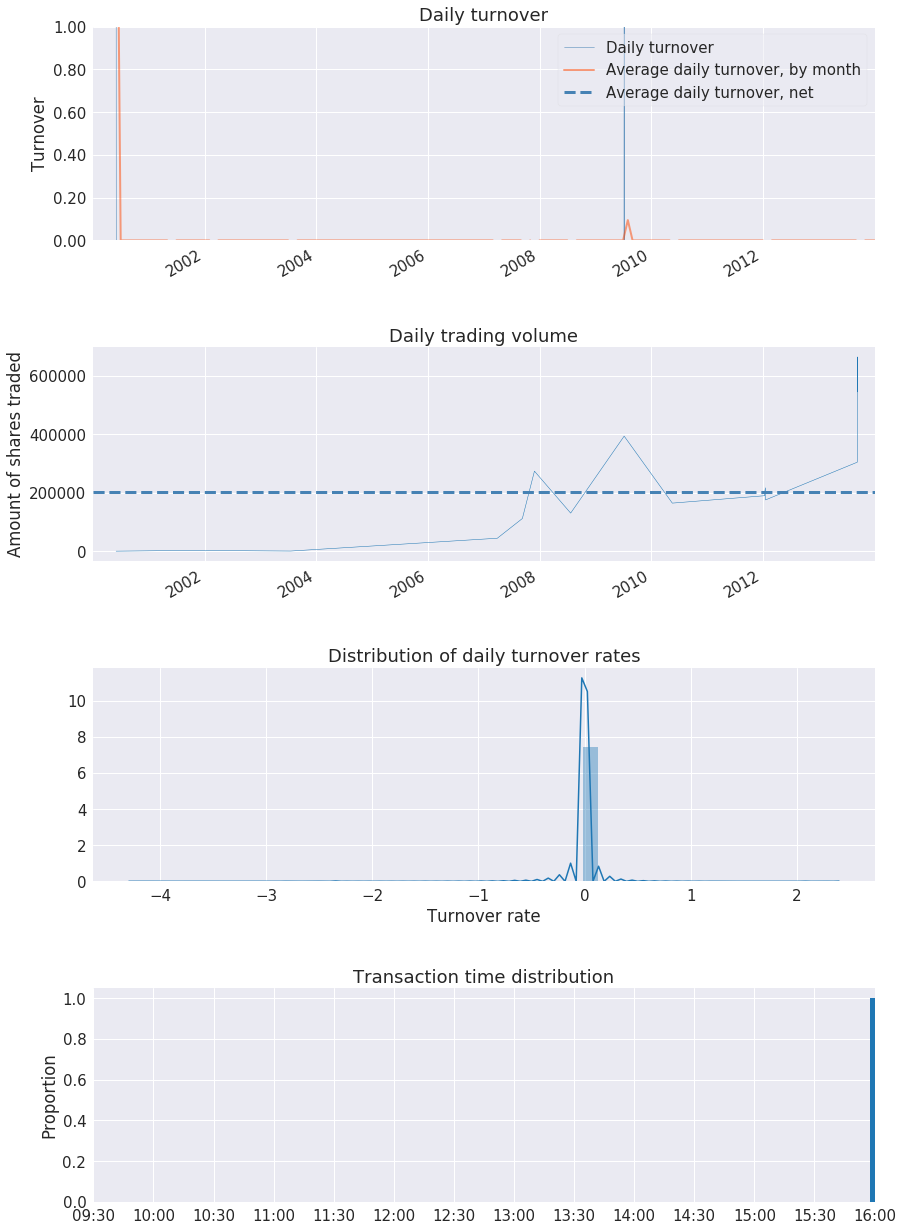

/usr/local/lib/python3.4/site-packages/pyfolio/tears.py:806: UserWarning: Fewer than 5 round-trip trades made.
               Skipping round trip tearsheet.
  Skipping round trip tearsheet.""", UserWarning)


In [15]:
pf.create_full_tear_sheet(returns, positions, transactions, round_trips=True)